# 15.5 Word Embedding with Global Vectors (GloVe)

자연어 처리 (NLP)는 사람의 말을 컴퓨터가 이해하도록 만드는 작업으로, 사람의 손으로 만든 유의어 사전(시소러스)을 활용하는 방법을 제외하면, 크게 두 종류의 기법이 있다.

1. 통계 기반 기법
2. 추론 기반 기법

으로 

통계적으로 특정 말뭉치(corpus)에서 co-occurrence matrix를 활용해 주변 단어의 빈도를 기초로 단어를 표현하여, 말 뭉치의 전체적인 통계 정보를 고려하는 **통계 기반 기법**과

신경망 등을 활용하여 학습하여 주변 단어가 주어졌을 때 알맞은 단어를 유추하는 **추론 기반 기법**이 있다.

GloVe 모델은 2014년 미국 스탠포드 대학에서 발표하였는데,

LSA(Latent Semantic Analysis)는 카운트 기반으로 말뭉치(corpus)의 전체적인 통계 정보를 고려하기는 하지만, 왕:남자 = 여왕:? (정답은 여자)와 같은 단어 의미의 유추 작업(Analogy task)에는 성능이 떨어짐. 

Word2Vec는 예측 기반으로 단어 간 유추 작업에는 LSA보다 뛰어나지만, 임베딩 벡터가 윈도우 크기 내에서만 주변 단어를 고려하기 때문에 말뭉치(corpus)의 전체적인 통계 정보를 반영하지 못함.

-> 이를 적절하게 섞어서 적용한다면??

##15.5.1 Skip-Gram with Global Corpus Statistics

skip-gram.svg

15.1.3 장에서 기술한 Skip-Gram model에서 단어 wi가 주어졌을 때, 단어 wj 가 나올 확률인 P(wj|wi)를 qij라고 했을 때, qij는 다음과 같이 나타낼 수 있다.

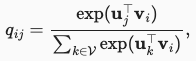

위 식에서 u는 context word vector, v는 center word vector이며, V는 vocabulary index set 임.

단어 wi가 corpus에서 여러번 나올 때, wi가 center word가 되는 context word들의 집합을 multiset Ci라고 가정할 수 있고, 등장횟수를 multiplicity라고 할 수 있다.

예를 들어, wi가 두 번 등장하고, 이때 context words가 각각 k,j,m,k / k,l,k,j일 때, multiset Ci = {j,j,k,k,k,k,l,m}이며 각 단어의 multiplicity는 j,k,l,m이 각각 2,4,1,1이 되는 것이다.

Context word j의 multiset Ci 안에서의 multiplicity를 xij라고 표현해보면, 이는 즉 전체 corpus에서 ceter word wi가 주어졌을 때, context word wj의 global co-occurrence count이다.

이를 활용했을 때, skip-gram model의 loss function (cross entropy loss) 은 다음과 같다.

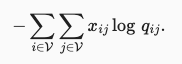

위 식에서 qij는 단어 wi가 주어졌을 때, 단어 wj가 나올 확률이고, xij는 실제로 corpus에서 등장한 횟수.

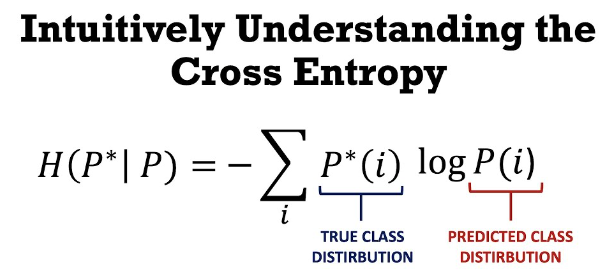

또한, xi를 wi가 center word로 제시되었을 때, context window 안에 있는 모든 context word의 수(|Ci| 로도 표현 가능)라고 가정했을 때, pij를 xij/xi로 가정하여 위 loss function을 나타낸 식을 아래와 같이 바꿔줄 수 있다.

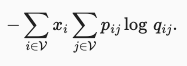

위 식에서 global corpus statistics에서 conditional distruibution pij의 cross-entropy 및 model prediction 시 conditional distribution qij를 같이 계산해줄 수 있다.

-> 통계 기반 기법 + 추론 기반 기법

##15.5.2 The GloVe Model

probability distribution 사이 간극을 평가하는데 cross-entropy loss를 주로 사용하지만, 이게 적합하지 않을 수 있다. 모든 단어에 대한 계산 처리 비용이 지나치게 많이 들 수 있다. 이를 고려하여 skip-gram model에 squared loss를 기반으로 세가지 변화를 주어서 만들었다.

1. variable pij를 xij로, qij를 exp(ujTvi)로 설정하여 squared loss term을 계산
2. 각 단어 wi에 center word bias bi와 context word bias ci라는 scalar값을 추가
3. 각 loss term의 weight를 weight function h(xij)로 대체 (h(x)는 0에서 1 사이)

이를 통해 아래와 같은 loss function을 도출

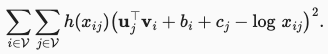

training하는 통안 SGD를 활용하여, 매 iteration마다 0이 아닌 xij의 미니배치를 임의로 모집하여 gradient를 계산하고, model parameter를 업데이트 할 수 있다. 이러한 non-zero xij는 precomputed global corpus statistics이므로 이 모델이 Global Vectors를 위한 GloVe model이라고 불린다.

##15.5.3 Interpreting GloVe from the Ratio of Co-occurrence Probabilities

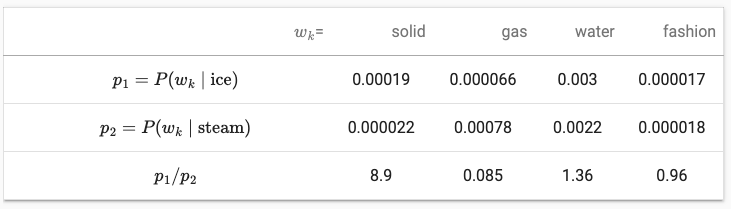

특정 단어 k가 주어졌을 때, 임베딩된 두 단어 벡터의 내적이 두 단어의 동시등장확률(co-occurrence probabilities) 간 비율이 되도록 임베딩하려고 함.

단어 상호 간 비율 정보를 Corpus 전체를 놓고 한꺼번에 반영하면 더 정확한 단어 임베딩이 될 것이다!

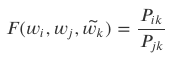

Pik = P(k|i)로, 사용자가 미리 정한 윈도우 내에서 i번째 단어와 k라는 단어가 동시에 등장한 빈도수(Xik)를 Xi로 나눠준 값을 의미.

위 표를 기준으로 설명하면 다음과 같은 식을 만족하는 함수 F를 찾으려고 함.

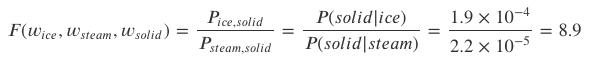

F 안에 들어갈 wi, wj, wk 간 관계 파악을 위해 wi와 wj를 뺀 벡터에 wk를 내적하여 다음과 같이 표현

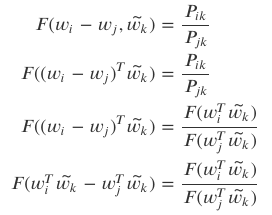

이 때 도출된 F는 다음 세가지 조건을 만족해함.

1. center word는 언제든지 바뀔 수 있기 때문에 wi와 wk를 서로 바꿔도 식이 같은 값을 반환해야 함.
2. co-occurrrence matrix X는 대칭행렬
3. homomorphism 조건을 만족해야 함.

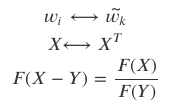

위 세가지 조건을 모두 만족하는 함수는 지수함수 이므로 F는 exp임을 확인할 수 있음.

따라서 F를 exp로 치환하고 식을 정리하면 다음과 같음.

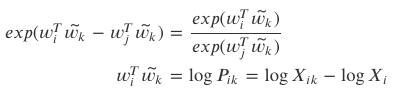

wi와 wk를 서로 바꿔도 식이 성립되기 위해서는 log(Pik)와 log(Pki) 또한 같아야됨.

따라서 scalar 값을 추가해줌.

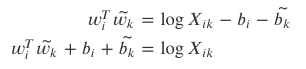

위 과정을 통해 앞서 보여준 GloVe model에서 objective function을 도출해낼 수 있음.

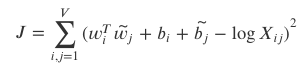

training corpus에서 지나치게 빈도가 높게 나오는 단어로 인해 Xij가 특정 값 이상으로 튀는 경우를 막기 위해 f(x)를 추가해준 것이 아래와 같은 최종적인 loss function임.

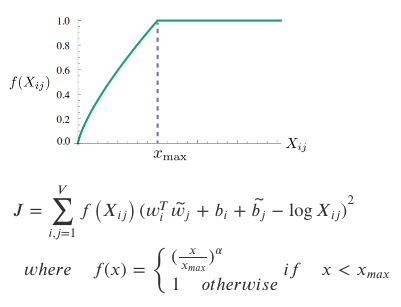

참고: https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/04/09/glove/

# 15.6 Subword Embedding

같은 단어이지만 표현형이 다른 단어들(help, helped, helps, helping 등)과 boy, boyfriend처럼 연관성 있는 단어들에 대해 지금까지 공부한 word2vec이나 GloVe 모델에서는 반영하지 못함.

## 15.6.1 The fastText model

단어 수준의 벡터 표현 대신 subword를 활용. 예를 들어 where를 wh, whe, her, ere, re의 subwords로 표현 가능. fastText에서는 특정 단어 w의 subwords (길이 3~6) 집합을 gw라고 정의하고, 이를 활용해 skip-gram 모델을 적용함.

이 때 계산복잡도가 높아지지만 유사한 구조를 가진 단어 사이의 subwords에서 parameter를 공유하여 희귀한 단어나 train corpus에 없는 단어(out-of-vocabulary words)도 얻을 수 있음.

## 15.6.2 Byte Pair Encoding

fastText 모델에서 단어를 3-6 길이로 잘랐는데, 아예 한 글자 단위로 자르고, training dataset에서 통계적 분석을 적용하여 각기 다른 길이의 흔한 조합을 찾아냄. 이를 변형하여 GPT-2나 RoBERTa와 같은 널리 쓰이는 장녀어 처리 모델이 구현됨.

먼저 알파벳 소문자와, 특별 기호 UNK, 단어 끝에 붙는 언더바를 활용한 symbols를 구성함.

In [ ]:
import collections

symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
           '_', '[UNK]']

단어 단위로 쪼개지 않기 때문에 각 단어의 등장 빈도를 나타내주는 raw_token_freqs 함수만 필요하다.

또한 각 심볼 사이의 구분 기호로 띄어쓰기를 활용함.

In [ ]:
raw_token_freqs = {'fast_': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4}
token_freqs = {}
for token, freq in raw_token_freqs.items():
    token_freqs[' '.join(list(token))] = raw_token_freqs[token]
token_freqs

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}

In [ ]:
raw_token_freqs.items()

dict_items([('fast_', 4), ('faster_', 3), ('tall_', 5), ('taller_', 4)])

corpus 내에서 가장 빈번한 symbol 쌍을 반환하는 get_max_freq_pair 함수를 정의.

In [ ]:
def get_max_freq_pair(token_freqs):
    pairs = collections.defaultdict(int)
    for token, freq in token_freqs.items():
        symbols = token.split()
        for i in range(len(symbols) - 1):
            # Key of `pairs` is a tuple of two consecutive symbols
            pairs[symbols[i], symbols[i + 1]] += freq
    return max(pairs, key=pairs.get)  # Key of `pairs` with the max value

In [ ]:
token_freqs.items()

dict_items([('f a s t _', 4), ('f a s t e r _', 3), ('t a l l _', 5), ('t a l l e r _', 4)])

merge_symbols 함수를 활용하여 가장 빈번하게 사용된 symbol 두개를 조합하여 새로운 symbol로 삽입하게 함.

In [ ]:
def merge_symbols(max_freq_pair, token_freqs, symbols):
    symbols.append(''.join(max_freq_pair))
    new_token_freqs = dict()
    for token, freq in token_freqs.items():
        new_token = token.replace(' '.join(max_freq_pair),
                                  ''.join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
    return new_token_freqs

이후 아래와 같이 for문을 활용하여 반복하면 다음과 같은 결과가 나옴.

In [ ]:
num_merges = 10
for i in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f'merge #{i + 1}:', max_freq_pair)

merge #1: ('t', 'a')
merge #2: ('ta', 'l')
merge #3: ('tal', 'l')
merge #4: ('f', 'a')
merge #5: ('fa', 's')
merge #6: ('fas', 't')
merge #7: ('e', 'r')
merge #8: ('er', '_')
merge #9: ('tall', '_')
merge #10: ('fast', '_')


첫 번째 단계에서 t, a 조합이 가장 흔하므로 ta가 새로운 symbol로 들어가고 이렇게 반복되어 다음과 같이 새로운 symbols 집합이 생겨남.

In [ ]:
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']


결과적으로 아래와 같은 하위 단어로 분리됨.

In [ ]:
print(list(token_freqs.keys()))

['fast_', 'fast er_', 'tall_', 'tall er_']


이 결과는 training dataset에 따라 달라질 수 있으며, 한 데이터셋에서 학습한 걸 기반으로 다른 데이터셋의 단어를 분할할 수도 있음.

In [ ]:
def segment_BPE(tokens, symbols):
    outputs = []
    for token in tokens:
        start, end = 0, len(token)
        cur_output = []
        # Segment token with the longest possible subwords from symbols
        while start < len(token) and start < end:
            if token[start: end] in symbols:
                cur_output.append(token[start: end])
                start = end
                end = len(token)
            else:
                end -= 1
        if start < len(token):
            cur_output.append('[UNK]')
        outputs.append(' '.join(cur_output))
    return outputs

In [ ]:
tokens = ['tallest_', 'fatter_']
print(segment_BPE(tokens, symbols))

['tall e s t _', 'fa t t er_']


#15.7 Word Similarity and Analogy

앞에서 작은 데이터셋에 대해 word2vec 모델을 훈련시켜서 이를 활용해 입력 단어와 의미적으로 유사한 단어를 찾았음. 실제로 대규모 corpus에서 NLP 적용은 16장 뒷부분에서 다룰 예정으로 큰 말뭉치에서 사전 훈련시킨 단어 벡터의 의미를 직관적으로 보여주기 위해 word similarity 및 analogy 작업에 이를 적용해보기로 함.

In [ ]:
!pip install d2l

In [ ]:
import os
import torch
from torch import nn
from d2l import torch as d2l

##15.7.1 Loading Pretrained Word Vectors

아래는 각각 50, 100, 300 차원의 pretrained GloVe embedding list를 불러오는 과정으로 영어 버전을 고려할 것임.

In [ ]:
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip',
                                '0b8703943ccdb6eb788e6f091b8946e82231bc4d')

d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip',
                                 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip',
                                  'b5116e234e9eb9076672cfeabf5469f3eec904fa')

d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip',
                           'c1816da3821ae9f43899be655002f6c723e91b88')

TokenEmbedding class를 통해 pretrained GloVe embedding을 불러옴.

In [ ]:
class TokenEmbedding:
    """Token Embedding."""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

우선 50-dimensional GloVe embedding을 불러오고

In [ ]:
glove_6b50d = TokenEmbedding('glove.6b.50d')

총 400,001단어가 있는 것을 확인할 수 있음

In [ ]:
len(glove_6b50d)

400001

In [ ]:
glove_6b50d.token_to_idx['beautiful'], glove_6b50d.idx_to_token[3367]

(3367, 'beautiful')

##15.7.2 Applying Pretrained Word Vectors

### 15.7.2.1 Word Similarity

15.4.3에서 한 것처럼 비슷한 단어를 찾기 위해 cosine similarity를 기반으로 word vector 간 유사도를 찾기 위해 k-nearest neighbors function을 구현

In [ ]:
def knn(W, x, k):
    # Add 1e-9 for numerical stability
    cos = torch.mv(W, x.reshape(-1,)) / (
        torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) *
        torch.sqrt((x * x).sum()))
    _, topk = torch.topk(cos, k=k)
    return topk, [cos[int(i)] for i in topk]

이후 pretrained word embedding에서 유사한 단어를 찾는다.

In [ ]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):  # Exclude the input word
        print(f'cosine sim={float(c):.3f}: {embed.idx_to_token[int(i)]}')

In [ ]:
get_similar_tokens('chip', 3, glove_6b50d)

cosine sim=0.856: chips
cosine sim=0.749: intel
cosine sim=0.749: electronics


In [ ]:
get_similar_tokens('baby', 3, glove_6b50d)

cosine sim=0.839: babies
cosine sim=0.800: boy
cosine sim=0.792: girl


In [ ]:
get_similar_tokens('beautiful', 3, glove_6b50d)

cosine sim=0.921: lovely
cosine sim=0.893: gorgeous
cosine sim=0.830: wonderful


In [ ]:
get_similar_tokens('korea', 3, glove_6b50d)

cosine sim=0.878: korean
cosine sim=0.851: pyongyang
cosine sim=0.842: dprk


###15.7.2.2 Word Analogy

man:woman = son:daughter 와 같이 의미 적으로 대응되는 관계를 찾는 방법

a:b = c:d 일때 vec(d)는 vec(c)+vec(b)-vec(a)로 표현하여 구한다.

In [ ]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]  # Remove unknown words

In [ ]:
get_analogy('man', 'woman', 'son', glove_6b50d)

'daughter'

In [ ]:
get_analogy('man', 'woman', 'father', glove_6b50d)

'mother'

In [ ]:
get_analogy('beijing', 'china', 'tokyo', glove_6b50d)

'japan'

In [ ]:
get_analogy('beijing', 'china', 'seoul', glove_6b50d)

'exporter'

In [ ]:
get_analogy('bad', 'worst', 'big', glove_6b50d)

'biggest'

In [ ]:
get_analogy('do', 'did', 'go', glove_6b50d)

'went'